1. Import Libraries

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, trim
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import udf

import pandas as pd
import matplotlib.pyplot as plt

2. Initialize Spark

In [0]:
spark = SparkSession.builder \
    .appName("MusicRecommendationSystem") \
    .getOrCreate()

3. Load Dataset

In [0]:
data_path = "/Volumes/first/default/music/dataset.csv" 


df = spark.read \
    .option("header","true") \
    .option("inferSchema","true") \
    .csv(data_path)

df.show(5)

+---+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------+
|_c0|            track_id|             artists|          album_name|          track_name|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|track_genre|
+---+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------+
|  0|5SuOikwiRyPMVoIQD...|         Gen Hoshino|              Comedy|              Comedy|        73|     230666|   False|       0.676| 0.461|  1|  -6.746|   0|      0.143|      0.0322|         1.01E-6|   0.358|  0.715| 87.917|           4

In [0]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- track_genre: string (nullable = true)



Safe Cleaning

In [0]:
df.createOrReplaceTempView("music_raw")

num_cols = [
    "danceability","energy","loudness","speechiness",
    "acousticness","instrumentalness","liveness",
    "valence","tempo","time_signature","duration_ms","popularity"
]

select_cols = []

for c in df.columns:
    if c in num_cols:
        select_cols.append(f"try_cast({c} as double) as {c}")
    else:
        select_cols.append(c)

query = "SELECT " + ",".join(select_cols) + " FROM music_raw"

df = spark.sql(query)

df = df.dropna(subset=num_cols)

df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- track_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- track_genre: string (nullable = true)



Preprocessing

In [0]:
# Drop unwanted column
if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0")

# Lowercase for search
df = df.withColumn("track_name_lower", lower(col("track_name")))

df.show(5)

+---+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------+--------------------+
|_c0|            track_id|             artists|          album_name|          track_name|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|track_genre|    track_name_lower|
+---+--------------------+--------------------+--------------------+--------------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-----------+--------------------+
|  0|5SuOikwiRyPMVoIQD...|         Gen Hoshino|              Comedy|              Comedy|      73.0|   230666.0|   False|       0.676| 0.461|  1|  -6.746|   0|      0.143|    

SQL Analysis

In [0]:
df.createOrReplaceTempView("music_clean")

spark.sql("""
SELECT track_genre, COUNT(*) AS total
FROM music_clean
GROUP BY track_genre
ORDER BY total DESC
LIMIT 10
""").show()


+-----------+-----+
|track_genre|total|
+-----------+-----+
|      chill| 1000|
|      blues| 1000|
|    ambient| 1000|
|alternative| 1000|
|      anime| 1000|
|   alt-rock| 1000|
|     brazil| 1000|
|   children| 1000|
|  breakbeat| 1000|
|black-metal| 1000|
+-----------+-----+



Pandas EDA

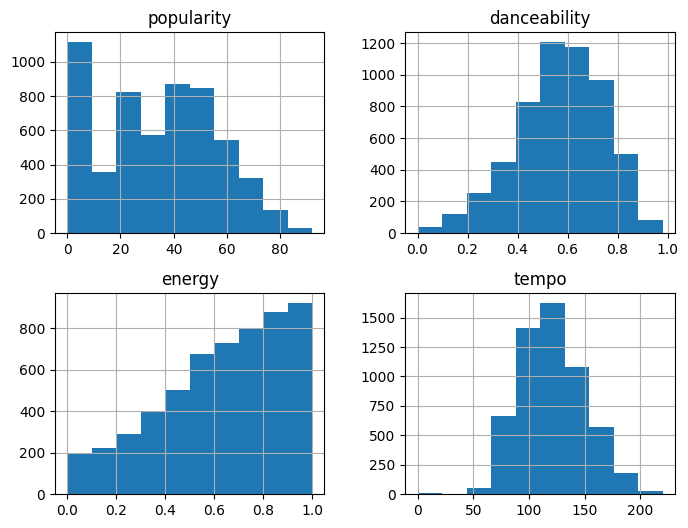

In [0]:
pd_df = df.sample(0.05).select(
    "popularity","danceability","energy","tempo"
).toPandas()

pd_df.hist(figsize=(8,6))
plt.show()

Encode Genre

In [0]:
indexer = StringIndexer(
    inputCol="track_genre",
    outputCol="genre_index",
    handleInvalid="skip"
)

df = indexer.fit(df).transform(df)

df.select("track_genre","genre_index").show(5)

+-----------+-----------+
|track_genre|genre_index|
+-----------+-----------+
|   acoustic|       98.0|
|   acoustic|       98.0|
|   acoustic|       98.0|
|   acoustic|       98.0|
|   acoustic|       98.0|
+-----------+-----------+
only showing top 5 rows


Feature Vector

In [0]:
features = [
    "danceability","energy","loudness","speechiness",
    "acousticness","instrumentalness","liveness",
    "valence","tempo","popularity","genre_index"
]

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

df = assembler.transform(df)

df.select("features").show(3)

+--------------------+
|            features|
+--------------------+
|[0.676,0.461,-6.7...|
|[0.42,0.166,-17.2...|
|[0.438,0.359,-9.7...|
+--------------------+
only showing top 3 rows


Scaling

In [0]:
df = df.filter(col("features").isNotNull())

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaled_features"
)

df = scaler.fit(df).transform(df)

df.select("scaled_features").show(3)


+--------------------+
|     scaled_features|
+--------------------+
|[3.89801817203680...|
|[2.42184560984535...|
|[2.52563899312444...|
+--------------------+
only showing top 3 rows


Train LSH Model for Similarity Search

In [0]:
from pyspark.ml.feature import BucketedRandomProjectionLSH


lsh = BucketedRandomProjectionLSH(
    inputCol="scaled_features",
    outputCol="hashes",
    bucketLength=2.0,
    numHashTables=3
)

lsh_model = lsh.fit(df)

lsh_df = lsh_model.transform(df)

lsh_df.show(3)


+---+--------------------+--------------------+----------------+----------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+-----------+----------------+-----------+--------------------+--------------------+--------------------+
|_c0|            track_id|             artists|      album_name|      track_name|popularity|duration_ms|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|track_genre|track_name_lower|genre_index|            features|     scaled_features|              hashes|
+---+--------------------+--------------------+----------------+----------------+----------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+-----------+----------------+-----------+--------------------+--------------------+-----------

In [0]:
kmeans = KMeans(
    k=12,
    seed=42,
    featuresCol="scaled_features",
    predictionCol="cluster"
)

model = kmeans.fit(df)

df = model.transform(df)

df.select("track_name","cluster").show(5)

+--------------------+-------+
|          track_name|cluster|
+--------------------+-------+
|              Comedy|      8|
|    Ghost - Acoustic|      1|
|      To Begin Again|      1|
|Can't Help Fallin...|      1|
|             Hold On|      0|
+--------------------+-------+
only showing top 5 rows


Model Evaluation

In [0]:
evaluator = ClusteringEvaluator(
    featuresCol="scaled_features",
    predictionCol="cluster"  
)

score = evaluator.evaluate(df)

print("Silhouette Score:", score)


Silhouette Score: 0.2304301302605353


Hybrid Recommendation Engine

In [0]:
def hybrid_recommend(song, top_n=10):

    song = song.lower()

    # Find base song
    base = lsh_df.filter(
        col("track_name_lower").like(f"%{song}%")
    ).limit(1)

    if base.count() == 0:
        print("Song not found")
        return

    base_vec = base.select("scaled_features").collect()[0][0]

    # Nearest Neighbors using LSH
    neighbors = lsh_model.approxNearestNeighbors(
        lsh_df,
        base_vec,
        top_n + 1
    )

    result = neighbors \
        .filter(col("distCol") > 0) \
        .select(
            "track_name",
            "artists",
            "album_name",
            "track_genre",
            "popularity",
            "distCol"
        ) \
        .orderBy(col("distCol"))

    return result


Run Recommendation

In [0]:
user_song = input("Enter your mood:")

out = hybrid_recommend(user_song,10)

out.show(truncate=False)


Enter your mood: happy

+----------------------------------+--------------------------------------+---------------------------------------+-----------------+----------+------------------+
|track_name                        |artists                               |album_name                             |track_genre      |popularity|distCol           |
+----------------------------------+--------------------------------------+---------------------------------------+-----------------+----------+------------------+
|Ranjha - Reprise                  |Jasleen Royal;B Praak;Romy;Anvita Dutt|Ranjha (Reprise)                       |songwriter       |49.0      |0.738987916364473 |
|Ranjha - Reprise                  |Jasleen Royal;B Praak;Romy;Anvita Dutt|Ranjha (Reprise)                       |singer-songwriter|49.0      |0.7708575449573069|
|Sappy - Early Demo                |Kurt Cobain                           |Montage Of Heck: The Home Recordings   |acoustic         |50.0      |0.9505075425361273|
|Olmasa Mektubun